# Let's Train Tiny MoE





### Configure the machine and install packages


In [1]:
from typing import Literal

import os

#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax

platform : Literal["darwin", "colab", "cuda", "tpu"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"
    if any(d.platform == "tpu" for d in devices):
        platform = "tpu"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on cuda


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/home/src


In [3]:
import os


import warnings

import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)

devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Set up device mesh


mesh = jax.sharding.Mesh(jax.devices(), ["devices"])

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.4
Available devices: 8
using gpu


864 μs ± 92.2 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the model and perform a sanity check

In [4]:
from datetime import datetime
import random
import string

from jaxpt.checkpointers import save_checkpoint, load_checkpoint, load_checkpoint_from_gcloud

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "cuda":
  output_dir = Path("/home/ubuntu/alpha_training_runs") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent  / "alpha_training_runs" # Local setup

Run: run_20250716_htlpzj


In [ ]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import Tiny_MoE_Config, Tiny_MoE
from jaxpt.utils import count_params, create_sharded_model

import tiktoken
from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = Tiny_MoE_Config(dtype=jnp.bfloat16, \
                     #vocab_size=49152,
                     n_layer=30,
                     block_size=1024,
                     n_head=9,
                     n_kv_head=3,
                     n_mlp_hidden=1536,
                     sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)

with mesh:
    m = create_sharded_model(Tiny_MoE, config, rngs)
    #m = load_checkpoint(Tiny_MoE, output_dir, config, "run_20250617_spwhty", 148, rngs)
    #m = load_checkpoint_from_gcloud(Mobile_LLM, config, output_dir, "alpha_training_runs", "run_20250521_pakugd", "9000", rngs)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)
    moe_params = count_params(m, "moe")

    print(f"Parameter Count: {total_params:,}")
    print(f"MOE Parameter Count: {moe_params:,}")
    print(f"Replicated Parameter Count: {total_params - moe_params:,}")
    nnx.display(state)

    #tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
    enc = tiktoken.get_encoding("gpt2")
    completions = generate_completions(m, enc=enc, num_completions=8,
                                    max_length=21,
                                    prefix="Ducks quack, donkeys bray, cats mew, horses")
    for completion in completions:
        print(completion)

2025-07-16 02:03:19.994540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752631400.012793  105488 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752631400.018354  105488 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752631400.034367  105488 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752631400.034383  105488 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752631400.034385  105488 computation_placer.cc:177] computation placer alr

Parameter Count: 414,377,280
MOE Parameter Count: 319,011,840
Replicated Parameter Count: 95,365,440


Ducks quack, donkeys bray, cats mew, horses plantation plantation plantation plantationportingporting
Ducks quack, donkeys bray, cats mew, horses ashes ashes ashes ashes ashes ashes
Ducks quack, donkeys bray, cats mew, horses modifying modifying modifying modifying modifying modifying
Ducks quack, donkeys bray, cats mew, horsesruptionruptionruptionruption AX AX
Ducks quack, donkeys bray, cats mew, horses Sat Sat Sat Sat Sat Sat
Ducks quack, donkeys bray, cats mew, horsesēēēēēē
Ducks quack, donkeys bray, cats mew, horsesportingportingportingportingportingporting
Ducks quack, donkeys bray, cats mew, horsesportingportingportingportingportingporting


### Configure Training Run

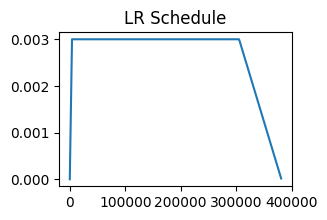

tokens/batch: 262,144
block size: 1024
batch size: 256
no. gradient accumulation steps: 1
effective batch size: 256
effective batch size per device:  32
max steps: 381,469


In [ ]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**18 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 32 * num_devices
  T: int = 1024
  max_steps: int = int((100e9) // (2**18))
  max_lr: float = 3e-3
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 4000
  print_interval: int = 5 
  eval_interval: int = 5000
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

# Set up the optimizer
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - 0.8 * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < 0.8 * trconf.max_steps, trconf.max_lr, cooldown_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ trapezoidal_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

tx = optax.chain(
    #optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adafactor(trapezoidal_schedule)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 20

print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB // num_devices)
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [ ]:
import os

from jaxpt.dataloaders import HuggingfaceDataLoader, CloudDataLoader

'''
train_dl = HuggingfaceDataLoader(batch_size=trconf.mB,
                                 block_size=trconf.T,
                                 device_rank=1,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)
'''

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./jaxpt/notebooks/alpha-448101-282bc1b884cd.json"

train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
                      bucket_prefix="fineweb-edu-100b/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")


CloudDataLoader initialized:
------------------------
label:          train
shards:         991
shard size:     100,000,000
batch size:     256
block size:     1024
device rank:    1
------------------------


In [ ]:
from jaxpt.utils import append_to_csv

# Create log dir
log_dir = output_dir / m.config.name / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
step = 0

Log directory: /home/ubuntu/alpha_training_runs/Tiny_MoE/logs


Evaluation TBD.0003 | loss: 2.6875 | time: 419.08ms | tokens processed: 98,304,262,144 | tok/sec: 625,516.8557


Evaluation TBD.0001 | loss: 2.7656 | time: 1108.30ms | tokens processed: 99,614,982,144 | tok/sec: 236,528.336


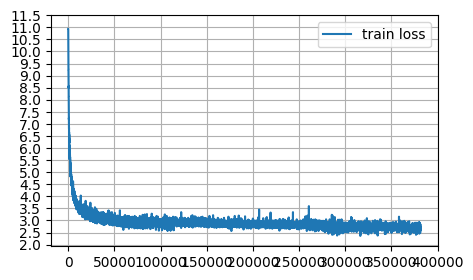

In [ ]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.train import train_step


with mesh:
  data_sharding = NamedSharding(mesh, PartitionSpec("devices",))
  m.train()
  try:
    while step < trconf.max_steps:
      start = time.time()
      batch, target = train_dl()
      batch = jax.device_put(batch.squeeze(), data_sharding)
      target = jax.device_put(target.squeeze(), data_sharding)
      avg_loss = train_step(m, optimizer, batch, target)
      #avg_loss.block_until_ready()
      iter_time = time.time() - start
      if step % trconf.print_interval == 0:
        avg_loss = avg_loss.item()
        lr = trapezoidal_schedule(step)
        sub_step_time = iter_time / trconf.grad_accumulation_steps
        tokens_per_sec = trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
        tokens_processed = (step+1) * trconf.grad_accumulation_steps * trconf.mB * trconf.T

        train_losses.append((step, avg_loss))
        append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, iter_time*1000, tokens_processed, tokens_per_sec])
        print(f"{step} | lr: {lr:0.4f} | "
              f"loss: {avg_loss:0.4f} | "
              f"time: {iter_time*1000:0.2f}ms | "
              f"tokens processed: {tokens_processed:,} | "
              f"tok/sec: {tokens_per_sec:,.2f}", end="\r")
      if step % trconf.eval_interval == 0:
        print("Evaluation TBD")
        save_checkpoint(m, output_dir, run_dirname, step)
      step += 1

  except KeyboardInterrupt:
      print("Received KeyboardInterrupt. Exiting...")

  plt.figure(figsize=(5, 3))
  plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
  plt.yticks(ticks=np.arange(2, 12, 0.5))
  plt.grid()
  plt.legend()
  plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
  plt.show()

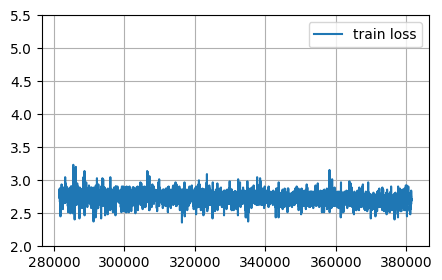

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot([x[0] for x in train_losses[-10000:]], [x[1] for x in train_losses[-10000:]], label="train loss")
plt.yticks(ticks=np.arange(2, 6, 0.5))
plt.grid()
plt.legend()
plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
save_checkpoint(m, output_dir, run_dirname, step)

In [ ]:
with mesh:
    m.eval()
    enc = tiktoken.get_encoding("gpt2")
    completions = generate_completions(m, enc=enc, num_completions=8,
                                    max_length=21,
                                    prefix="The People's Republic of China was founded in",
                                    key=jax.random.key(2))
    for completion in completions:
        print(completion)

The People's Republic of China was founded in a the the the the the the the the the the the
The People's Republic of China was founded in a the a revolution. It was revolution of the a people
The People's Republic of China was founded in a the a revolution.
The People's Left Party is
The People's Republic of China was founded in a a revolution.
The People's Republic of China was
The People's Republic of China was founded in a a revolution, and the Chinese people have been a fighting
The People's Republic of China was founded in a the the a a a a a a a a a
The People's Republic of China was founded in a a revolution. The people of people of the country of
The People's Republic of China was founded in a a revolution.
The People's Republic of China was
